<center><h1>Ensemble Model Prediction</h1></center>
Combining Two models, One trained to identify class 1 with high precision and other to identify class 0 with high precision. Individually, they have low performance, but when combined they deliver high performance. We also get to know with certainty that all the samples predicted by Model 1 as class 1 are indeed very likely class 1 and all the samples predicted by Model 2 as class 0 are indeed very likely class 0.

In [ ]:
# Model 1 : High Precision for class 1 | XGB Classifier | Low overall performance
# Model 2 : High Precision for class 0 | Neural Network | Low overall performance
# Meta Model : Balanced Precision | Neural Network | High overall performance (Combines Model 1 and Model 2)

# 1. Import Requirements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load
from xgboost import XGBClassifier
import tensorflow as tf

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score

2024-10-08 14:36:49.595956: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-08 14:36:49.618700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-08 14:36:49.643591: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-08 14:36:49.651080: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-08 14:36:49.669883: I tensorflow/core/platform/cpu_feature_guar

# 2. Load the Dataset for Prediction

## 2.1. Define File Paths

In [2]:
# Please set the paths
x_test_csv_path = 'dataset_original/Test_20/X_Test_Data_Input.csv' #Put the validation/test input dataset csv file path here.
pred_out = 'predictions.csv' #Save-file path after making predictions. Predictions by the model will be saved in this file location.

In [3]:
# Save Folder Path: Folder which contains pretrained models, preprocessing configurations and logs. (We have pretrained the final model which can be used to make predictions)
save_folder = 'saves/save_final_ensemble_model/'

if not save_folder.endswith('/'):
    save_folder += '/'

## 2.2. Load the Dataset

In [4]:
# Load the dataset
X_test = pd.read_csv(x_test_csv_path)

# Print the shapes of the datasets
print(f"Shape of X_Test: {X_test.shape}")

Shape of X_Test: (261712, 23)


## 2.3. Test the Dataset

In [5]:
expected_columns = ['ID'] + [f'Column{i}' for i in range(22)]

# Check if X_test has exactly 23 columns and if their names match the expected columns
if list(X_test.columns) == expected_columns:
    print("Test PASSED: The dataset has exactly 23 columns with the correct names.")
else:
    print("WARNING: The dataset does not have 23 columns or the column names do not match.")

Test PASSED: The dataset has exactly 23 columns with the correct names.


# 3. Dataset Preprocessing

## 3.1. Drop the ID column

In [6]:
ids = X_test['ID']  # Store the 'ID' column

# Drop the 'ID' column
X_test.drop(columns=['ID'], inplace=True)

## 3.2. Cap the Outliers

In [7]:
# Caping/Binning the test dataset
cap_dict = load(save_folder+'preprocessing_config/cap_dict.joblib')
for col in cap_dict:
    print(f'{col} : low= {cap_dict[col][0]} | high= {cap_dict[col][1]}')
    X_test[col] = np.clip(X_test[col], cap_dict[col][0], cap_dict[col][1])

Column5 : low= None | high= 10.880524016040438
Column6 : low= None | high= 3.440526788922186
Column7 : low= None | high= 45.36292569302045
Column8 : low= None | high= 13.786297944822405
Column9 : low= None | high= 10.478853569536852
Column14 : low= 0.001242022717049515 | high= 0.001370555723753345
Column15 : low= -0.23901038570283042 | high= 0.007882046956824504
Column17 : low= None | high= 120


## 3.3. Feature Engineering
Adding Features Manually

In [8]:
# Apply to test set
most_frequent_value_15 = load(save_folder+'preprocessing_config/most_frequent_value_15.joblib')

X_test['Column9_NA'] = X_test['Column9'].isna().astype(int)

X_test['Column14_NA'] = X_test['Column14'].isna().astype(int)

X_test['Column15_Frequent'] = (X_test['Column15'] == most_frequent_value_15).astype(int)

## 3.4. Scaling

### Handling Categorical Data (Min-Max normalization)

In [9]:
# Apply scaler to the testing set
multi_catogarical_columns = ['Column0', 'Column16', 'Column17']
min_max_scaler = MinMaxScaler()
min_max_scaler = load(save_folder+'preprocessing_config/min_max_scaler.joblib')
X_test[multi_catogarical_columns] = min_max_scaler.transform(X_test[multi_catogarical_columns])

### Z-Normalization

In [10]:
# Apply scaler to the testing set
non_catogarical_columns = ['Column1', 'Column2', 'Column3', 'Column4', 'Column5', 'Column6', 'Column7', 'Column8', 'Column9', 'Column14', 'Column15']
z_scaler = StandardScaler()
z_scaler = load(save_folder+'preprocessing_config/z_scaler.joblib')
X_test[non_catogarical_columns] = z_scaler.transform(X_test[non_catogarical_columns])

## 3.5. Imputation : Handling the missing values

In [11]:
# Impute the Test dataset
mice_columns = ['Column0', 'Column3', 'Column4', 'Column5', 'Column6', 'Column8', 'Column9', 'Column14', 'Column15']
mice_imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=20, tol=0.01, random_state=42)

# Load the imputer
mice_imputer = load(save_folder+'preprocessing_config/mice_imputer.joblib')

# Use the loaded imputer to transform new data
X_test[mice_columns] = mice_imputer.transform(X_test[mice_columns])

In [12]:
# If there are any other missing values (in the columns where training dataset didn't have any), handel them using median Imputation

# Create the imputer for median imputation
median_imputer = SimpleImputer(strategy='median')

# Perform median imputation
X_test = median_imputer.fit_transform(X_test)

# 4. Load the Models

## 4.1. Model 1 (Robust to class 1)
XGB Classifier whose precision (from the view point of class 1) is high, so that the model robustly classifies class 1 (i.e. extremely low flase positives)

In [13]:
# Load the model
model_1 = XGBClassifier()
model_1.load_model(save_folder+'tf_models/model_xgb_robust_class_1.json')

## 4.2. Model 2 (Robust to class 0)

In [14]:
model_2 = tf.keras.models.load_model(save_folder+'tf_models/model_nn_robust_class_0.keras')

2024-10-08 14:37:37.153977: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6719 MB memory:  -> device: 0, name: NVIDIA T1000 8GB, pci bus id: 0000:af:00.0, compute capability: 7.5


## 4.3. Load the Meta Model

In [15]:
model_meta = tf.keras.models.load_model(save_folder+'tf_models/model_meta_nn.keras')

# 5. Make Predictions

## 5.1. Extract Probabilities from Model 1 and Model 2
Then stack them to use it as an input to the meta model

In [16]:
pred_1_test = model_1.predict_proba(X_test)[:, 1]
pred_2_test = model_2.predict(X_test)

preds_test = np.column_stack((pred_2_test, pred_1_test))

I0000 00:00:1728378463.258622  247745 service.cc:146] XLA service 0x7fa1c4002280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728378463.258691  247745 service.cc:154]   StreamExecutor device (0): NVIDIA T1000 8GB, Compute Capability 7.5
2024-10-08 14:37:43.273107: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-08 14:37:43.368865: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  82/8179 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step    

I0000 00:00:1728378463.996679  247745 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8179/8179 ━━━━━━━━━━━━━━━━━━━━ 9s 938us/step


## 5.2. Make the final Predictions using Meta Model
Make predictions on the Model 1 & Model 2 outputs using a Neural Network

In [17]:
# Make predictions on the test set
Y_pred_prob = model_meta.predict(preds_test)

8179/8179 ━━━━━━━━━━━━━━━━━━━━ 7s 770us/step


In [18]:
Y_pred = (Y_pred_prob > 0.5).astype(int).flatten()

## 5.3. Save the final Predictions

In [19]:
Y_pred = pd.DataFrame({
    'ID': ids,
    'Predictions': Y_pred
})

In [20]:
Y_pred.to_csv(pred_out, index=False)

# 6. Test the Final Predictions

## 6.1. Load the Final predictions and the True Labels

In [21]:
# Define the file paths
y_test_csv_path = 'dataset_original/Test_20/Y_Test_Data_Target.csv'
y_pred_csv_path = pred_out

In [22]:
# Load the true labels and predictions
Y_test = pd.read_csv(y_test_csv_path)
Y_pred = pd.read_csv(y_pred_csv_path)

## 6.2. Test the dataset

In [23]:
# check if both the sets have same number rows
if(Y_test.shape[0] == Y_pred.shape[0]):
    print("Test PASSED: Number of rows are the same")
else:
    print("WARNING: Number of true samples and predicted samples doesn't match!")

Test PASSED: Number of rows are the same


In [24]:
# check if both the sets have same IDs for each row
if((Y_test['ID'] == Y_pred['ID']).all()):
    print("Test PASSED: IDs match in both datasets")
else:
    print("WARNING: IDs do not match!")

Test PASSED: IDs match in both datasets


## 6.3. Results of the Predictions

In [25]:
# Drop the 'ID' column
Y_test.drop(columns=['ID'], inplace=True)
Y_pred.drop(columns=['ID'], inplace=True)

Meta Model Accuracy: 97.83%

Confusion Matrix:
[[233017   4017]
 [  1673  23005]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    237034
           1       0.85      0.93      0.89     24678

    accuracy                           0.98    261712
   macro avg       0.92      0.96      0.94    261712
weighted avg       0.98      0.98      0.98    261712



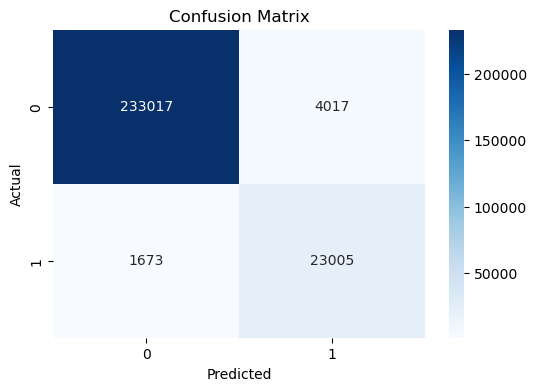

Precision: 0.85
Recall: 0.93
F1-Score: 0.89
ROC-AUC: 0.96


In [26]:
# Evaluate the model
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Meta Model Accuracy: {accuracy * 100:.2f}%")

# Confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
print("\nConfusion Matrix:")
print(cm)

# Classification report
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred))

# Visualizing the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Precision, Recall, F1-Score
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
roc_auc = roc_auc_score(Y_test, Y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")